<div style="background:#F5F7FA; height:100px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Want to do more?</span><span style="border: 1px solid #3d70b2;padding: 15px;float:right;margin-right:40px; color:#3d70b2; "><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
<span style="color:#5A6872;"> Try out this notebook with your free trial of IBM Watson Studio.</span>
</div>

# Analyzing data by using the Sparkling.data library features

In this notebook, we will use Python and the Sparkling.data library to discover, clean, and analyze a variety of medical patient and prescription drug data sources. Each section of the notebook explores how the Sparkling.data library can be used to analyze data in different formats. 

Some familiarity with Python is recommended. This notebook runs on Python 2 with Spark 2.1.

You may have completely structured data provided in a table or database, or your data might be completely unstructured, such as a letter written in a PDF document. The Sparkling.data library provides several tools that you can use to approach data for analysis differently depending on the type of data to be analyzed.

## Table of contents

- [Setup](#Setup) 
- [Analyzing structured data](#Analyzing-structured-data)
 - [Discovering multiple file types in a directory](#Discovering-multiple-file-types-in-a-directory)
 - [Profiling and exploring statistics and distributions](#Profiling-and-exploring-statistics-and-distributions)
 - [Visualizing data distributions](#Visualize-data-distributions)
 - [Revealing and fixing bad data](#Revealing-and-fixing-bad-data)
 - [Save the DataFrame](#Save-the-DataFrame)
- [Analyzing data with semantic meaning](#Analyzing-data-with-semantic-meaning)
 - [Discovering semantic types](#Discovering-semantic-types)
 - [Revealing and fixing bad semantic data](#Revealing-and-fixing-bad-semantic-data)
 - [Tuning data quality](#Tuning-data-quality)
- [Analyzing unstructured data](#Analyzing-unstructured-data)
- [Summary](#Summary)


# Setup

Before you can use the example code in this notebook, you need to import extension utilities and create a Spark SQLContext by running the following cell:

In [1]:
from pyspark.sql import SQLContext 
sqlContext = SQLContext(sc)
from ingest import *
eu = ExtensionUtils(sqlContext)

### Import the packages required for vizualization

The following commands import visualization libraries that will allow you to plot type and data distributions of your data:

In [2]:
import brunel
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import pandas as pd

### Load the drug data set

Load the data set by downloading and unzipping `sparklingdataset.zip`:

In [3]:
!wget --quiet  --output-document sparklingdataset.zip https://ibm.box.com/shared/static/gypaznljmh9h2g5kmkyirc3zqu7dfzkn.zip
!unzip -o sparklingdataset.zip -d sparklingdata/
!rm sparklingdataset.zip

Archive:  sparklingdataset.zip
  inflating: sparklingdata/data/.DS_Store  
  inflating: sparklingdata/data/sampleDataDir/customers.csv  
  inflating: sparklingdata/data/sampleDataDir/drugInfo2014.json  
  inflating: sparklingdata/data/sampleDataDir/drugInfo2015.json  
  inflating: sparklingdata/data/sampleDocsDir/Events.doc  
  inflating: sparklingdata/data/sampleDocsDir/News.pdf  


# Analyzing structured data

This section of the notebook explores the drug data, which is structured in comma-delimited files. However, the data is split among several different files of various types.

## Discovering multiple file types in a directory

You can use the Sparkling.data library to identify file types within a folder and subfolders containing different types of files, for example, `.csv` or `.json`. 

The following command uses the listDiscoveredTypes API to list the different file types in the `sampleDataDir` directory:

In [4]:
dfDiscovered = sqlContext.read.format("com.ibm.spark.discover").option("listDiscoveredTypes", "true").load("sparklingdata/data/sampleDataDir")
dfDiscovered.printSchema()
dfDiscovered.show()

root
 |-- Type: string (nullable = false)
 |-- Count: string (nullable = false)

+----------------+-----+
|            Type|Count|
+----------------+-----+
|application/json|    2|
|        text/csv|    1|
+----------------+-----+



### Discovering drug data from multiple file types

The Sparkling.data library discovers the data in your files and returns a DataFrame representing data from the most often occuring file type. In this case, drug data from the `.json` files will be loaded.

In [5]:
dfDrug = sqlContext.read.format("com.ibm.spark.discover").load("sparklingdata/data/sampleDataDir")
dfDrug.printSchema()
dfDrug.show(5)

root
 |-- Age: long (nullable = true)
 |-- BP: string (nullable = true)
 |-- Cholestrol: string (nullable = true)
 |-- Cost: string (nullable = true)
 |-- DateTested: string (nullable = true)
 |-- Drug: string (nullable = true)
 |-- Ent#: long (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Potassium: double (nullable = true)
 |-- Sodium: double (nullable = true)

+---+------+----------+--------+-------------------+-----+----+------+---------+--------+
|Age|    BP|Cholestrol|    Cost|         DateTested| Drug|Ent#|Gender|Potassium|  Sodium|
+---+------+----------+--------+-------------------+-----+----+------+---------+--------+
| 34|  HIGH|    NORMAL|1.981,09|1980-10-11T10:10:20|drugY|  12|     F| 0.034782|0.667775|
| 43|   LOW|      HIGH|8.010,11|1980-10-11T10:10:20|drugY|  13|     M| 0.040746|0.626527|
| 74|   LOW|      HIGH|   10,11|1980-10-11T10:10:20|drugY|  14|     F| 0.037851|0.792674|
| 50|NORMAL|      HIGH|5.000,14|1990-05-14T05:12:05|drugX|  15|     F| 0.065166|

You can then use the library features to infer the data type of each column of the drug data and convert the data in each column to the inferred data type. If one of the rows in a specific column does not match with the inferred data type, it will be converted to null or NaN. You can then view a DataFrame with the converted schema:

In [6]:
dfConverted = eu.convertTypes(dfDrug)
dfConverted.printSchema()
dfConverted.show()

root
 |-- Age: long (nullable = true)
 |-- BP: string (nullable = true)
 |-- Cholestrol: string (nullable = true)
 |-- Cost: short (nullable = true)
 |-- DateTested: timestamp (nullable = true)
 |-- Drug: string (nullable = true)
 |-- Ent#: long (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Potassium: double (nullable = true)
 |-- Sodium: double (nullable = true)

+---+------+----------+----+--------------------+-----+----+------+---------+--------+
|Age|    BP|Cholestrol|Cost|          DateTested| Drug|Ent#|Gender|Potassium|  Sodium|
+---+------+----------+----+--------------------+-----+----+------+---------+--------+
| 34|  HIGH|    NORMAL|null|1980-10-11 05:10:...|drugY|  12|     F| 0.034782|0.667775|
| 43|   LOW|      HIGH|null|1980-10-11 05:10:...|drugY|  13|     M| 0.040746|0.626527|
| 74|   LOW|      HIGH|null|1980-10-11 05:10:...|drugY|  14|     F| 0.037851|0.792674|
| 50|NORMAL|      HIGH|null|1990-05-14 00:12:...|drugX|  15|     F| 0.065166| 0.82778|
| 16|  HI

## Profiling and exploring statistics and distributions
You can now use the Sparkling.data library's profile API to generate data distributions of the type, range, and other statistics for each column of the data.

In [7]:
dfProfile = eu.profile(dfConverted)

### Rendering profiled data for statistics

You can view the profiled data to help with your analysis:

In [8]:
dfRender = eu.render(dfProfile,RenderType.STATS)
dfRender.show()
dfRender_pd = dfRender.toPandas()

+--------------------+-------------------+------+
|                name|              value|column|
+--------------------+-------------------+------+
|               count|               30.0|   Age|
|             minimum|               16.0|   Age|
|             maximum|               74.0|   Age|
|               range|               58.0|   Age|
|                mean|  43.06666666666667|   Age|
|        harmonicMean| 37.839480371602065|   Age|
|            variance|  205.0298850574709|   Age|
|              stdDev|   14.3188646567202|   Age|
|          stdErrMean|   2.61425505678304|   Age|
|coefficientVariation| 0.3324813774780232|   Age|
|            skewness| 0.1544988612965501|   Age|
|      stdErrSkewness| 0.4268923959512381|   Age|
|            kurtosis|-0.3402939804536271|   Age|
|      stdErrKurtosis| 0.8327456183576328|   Age|
|               count|               17.0|  Cost|
|             minimum|               11.0|  Cost|
|             maximum|              811.0|  Cost|


## Visualizing data distributions

Run the following cell to prepare the data for visual analysis:

In [9]:
discovered_labels_BP = eu.render(dfProfile,RenderType.LABELS).select("name", "value", "column").filter("column = 'BP'")
discovered_histogram_Cost =  eu.render(dfProfile,RenderType.HISTOGRAM).select("name","value", "column").filter("column = 'Cost'")
discovered_labels_Drug =  eu.render(dfProfile,RenderType.LABELS).select("name","value", "column").filter("column = 'Drug'")
pd_discovered_labels_BP = discovered_labels_BP.toPandas()
pd_discovered_histogram_Cost = discovered_histogram_Cost.toPandas()
pd_discovered_labels_Drug = discovered_labels_Drug.toPandas()

This first visual example creates pie charts that explore the distribution of values found in the blood pressure and drug data:

/gpfs/fs01/user/sf9b-795b2b888c32b6-772f4e1cd93d/.local/lib/python2.7/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


(-1.111224730851283,
 1.1158727098791645,
 -1.1144470677999774,
 1.1006879564656726)

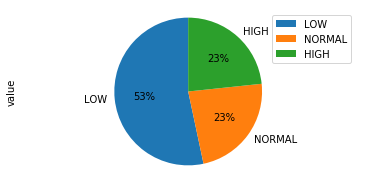

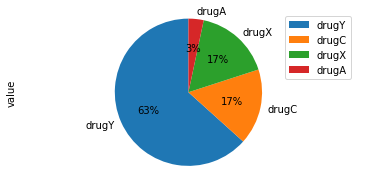

In [10]:
pd_discovered_labels_BP.plot.pie(labels=pd_discovered_labels_BP.name,subplots=True,figsize=(6,3),autopct="%1.0f%%",startangle=90)
plt.axis("equal")
pd_discovered_labels_Drug.plot.pie(labels=pd_discovered_labels_Drug.name,subplots=True,figsize=(6,3),autopct="%1.0f%%",startangle=90)
plt.axis("equal")

# Run the following cell to create a histogram that visualizes the distribution of the drug cost data:

<function matplotlib.pyplot.show>

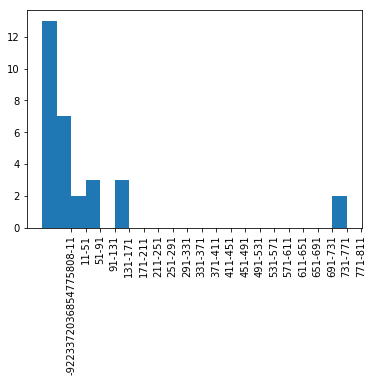

In [11]:
indexes = np.arange(len(pd_discovered_histogram_Cost['value']))
width = 1
plt.bar(indexes, pd_discovered_histogram_Cost['value'],width)
plt.xticks(indexes + width + 0.5, pd_discovered_histogram_Cost['name'], rotation='vertical')
plt.show

## Revealing and fixing bad data

Note that the cost column includes several null values. The original data set did not contain null values, so this indicates that the type mismatches resulted in null values during the type conversion. The Sparkling.data library's revealNA function provides visibility to the mismatched values so you can fix and include them instead of eliminating them:

In [12]:
enrichType_obj = eu.enrichType(dfDrug)
enrichType_obj = eu.setRevealBrackets(enrichType_obj,(">[", "]<"))
enrichType_obj = eu.setRevealMode(enrichType_obj,RevealMode.ANY)
dfDrugForAnalysis = eu.revealNA(enrichType_obj)
dfDrugForAnalysis.show()
dfDrugForAnalysis.count()

+---+------+----------+------------+-------------------+-----+----+------+---------+--------+
|Age|    BP|Cholestrol|        Cost|         DateTested| Drug|Ent#|Gender|Potassium|  Sodium|
+---+------+----------+------------+-------------------+-----+----+------+---------+--------+
| 34|  HIGH|    NORMAL|>[1.981,09]<|1980-10-11T10:10:20|drugY|  12|     F| 0.034782|0.667775|
| 43|   LOW|      HIGH|>[8.010,11]<|1980-10-11T10:10:20|drugY|  13|     M| 0.040746|0.626527|
| 74|   LOW|      HIGH|   >[10,11]<|1980-10-11T10:10:20|drugY|  14|     F| 0.037851|0.792674|
| 50|NORMAL|      HIGH|>[5.000,14]<|1990-05-14T05:12:05|drugX|  15|     F| 0.065166| 0.82778|
| 16|  HIGH|    NORMAL|    >[1,11]<|1980-10-11T10:10:20|drugY|  16|     F| 0.053742|0.833837|
| 69|   LOW|    NORMAL| >[1.514,9]<|1990-05-14T05:12:05|drugX|  17|     M| 0.074111|0.848948|
| 43|  HIGH|      HIGH|>[2.005,14]<|2009-05-14T05:12:05|drugA|  18|     M| 0.046979|0.656371|
| 23|   LOW|      HIGH|>[1.911,14]<|1980-11-14T09:10:20|drug

13

In this case, the mismatched values are float data type values in the Spanish language locale. Run the following cell to fix the conversion of these data types by providing the Spanish locale option:

In [13]:
dfFixed_enrichTypelocale = eu.enrichType(dfDrug).setLocale("es")
dfFixed = eu.convertTypes(dfFixed_enrichTypelocale)
dfFixed.printSchema()
dfFixed.show()

root
 |-- Age: long (nullable = true)
 |-- BP: string (nullable = true)
 |-- Cholestrol: string (nullable = true)
 |-- Cost: float (nullable = true)
 |-- DateTested: timestamp (nullable = true)
 |-- Drug: string (nullable = true)
 |-- Ent#: long (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Potassium: double (nullable = true)
 |-- Sodium: double (nullable = true)

+---+------+----------+-------+--------------------+-----+----+------+---------+--------+
|Age|    BP|Cholestrol|   Cost|          DateTested| Drug|Ent#|Gender|Potassium|  Sodium|
+---+------+----------+-------+--------------------+-----+----+------+---------+--------+
| 34|  HIGH|    NORMAL|1981.09|1980-10-11 05:10:...|drugY|  12|     F| 0.034782|0.667775|
| 43|   LOW|      HIGH|8010.11|1980-10-11 05:10:...|drugY|  13|     M| 0.040746|0.626527|
| 74|   LOW|      HIGH|  10.11|1980-10-11 05:10:...|drugY|  14|     F| 0.037851|0.792674|
| 50|NORMAL|      HIGH|5000.14|1990-05-14 00:12:...|drugX|  15|     F| 0.06516

The 'Cost' column type is now changed from Short to Float.

Now that you have fixed the mismatched values, you can profile the data again:

In [14]:
dfProfileFixed = eu.profile(dfFixed)
df_stats = eu.render(dfProfileFixed,RenderType.STATS)
stats = df_stats.filter("name != 'variance'")
pd_stats = stats.toPandas()
%brunel data('pd_stats') area x(name) yrange(0,value) sort(value):: width=500, height=500

<IPython.core.display.Javascript object>

The distributions on the fixed cost column show data in the 8000 range as expected, since that data point was a mismatched value that you have fixed. In fact, the column has no null values now because you fixed all of the mismatches, and that data is now included as Spanish float values. The data set is now clean and ready for analysis.

<function matplotlib.pyplot.show>

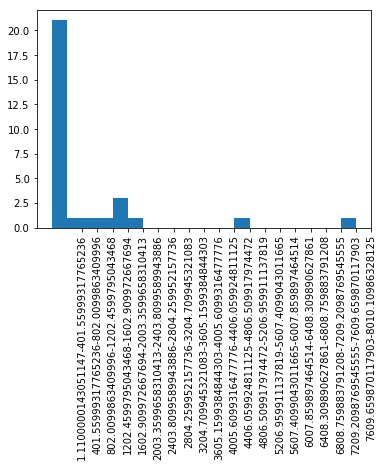

In [15]:
fixed_histogram_Cost =  eu.render(dfProfileFixed,RenderType.HISTOGRAM).select("name","value", "column").filter("column = 'Cost'")
pd_fixed_histogram_Cost = fixed_histogram_Cost.toPandas()
indexes = np.arange(len(pd_fixed_histogram_Cost['value']))
width = 1
plt.bar(indexes, pd_fixed_histogram_Cost['value'],width)
plt.xticks(indexes + width + 0.5, pd_fixed_histogram_Cost['name'], rotation='vertical')
plt.show

### Save the DataFrame
Run the following cell to save the DataFrame to a new `.json` file, called `drugdfFixed.json`:

In [16]:
dfFixed.write.format("com.ibm.spark.discover").mode("overwrite").save("sparklingdata/data/drugdfFixed1.json")

# Analyzing data with semantic meaning

Now that you have analyzed the drug data, you can also explore the Customer data.
The following section will help you to discover the Customer data, identify the semantic types of fields, and tune the data quality based on your desired thresholds. 

By default, the most often occuring file type is used for analysis, but if you want to view data from a specific file type, you can use the getType option. For example, the following command loads `.csv` files:

In [17]:
dfCust = sqlContext.read.format("com.ibm.spark.discover").option("getType", "csv").load("sparklingdata/data/sampleDataDir")

# Renaming the default column names
oldColumns = dfCust.schema.names
newColumns = ["Id", "Name","Organization","Address","Value"]
dfCustomers = reduce(lambda dfCust, idx: dfCust.withColumnRenamed(oldColumns[idx], newColumns[idx]), xrange(len(oldColumns)), dfCust)
dfCustomers.printSchema()
dfCustomers.show()

root
 |-- Id: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Organization: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Value: string (nullable = true)

+-----+--------------------+--------------------+--------------------+-------+
|   Id|                Name|        Organization|             Address|  Value|
+-----+--------------------+--------------------+--------------------+-------+
|t1234|           Tracy Doe|     Bank of America|     69221 Newman Rd|    250|
|t5566|       Lisa McDonald|         Wells Fargo|      555 Bailey Ave|   1000|
|t7666|    Lonnie Leo Gomez|       Bank of Texas|     1234 Airline Dr|   2000|
|t5567|    Stephen Brewster|First Bank of Ame...|   4589 Holly Street|3500.25|
|t1238|         Smith, Mary|         J.P. Morgan|3821 Twin Oaks Drive|   5000|
|t1239|          Jen Norman|       Bank of Texas|   4589 Holly Street|    230|
|t5823|     Mary Burchfield|     Bank of America|     69221 Newman Rd|   1500|
|t9954|       

## Discovering semantic types

This customer data does not have a header. The Sparkling.data library's SemanticTypes option can identify the data type of each column, and the library's inferTypes option proposes the type and enriches the DataFrame's metadata. In this case, the semantic types proposed include `person names`, `organization names`, and `addresses`.

In [18]:
dfCustomersInferred = eu.enrichType(dfCustomers).semanticType(True).inferTypes()
eu.printInferredTypes(dfCustomersInferred)


Id:{"inferred_type":"String","columnSpec":{"type":"String"},"inferred_occurrence":100.0,"DiscoveredDataTypePercentages":[1.0],"threshold":50,"DiscoveredDataTypes":["String"]}
Name:{"inferred_type":"US Name","columnSpec":{"type":"US Name"},"inferred_occurrence":67,"DiscoveredDataTypePercentages":[0.6774193548387096,0.25806451612903225,0.03225806451612903,0.03225806451612903],"threshold":50,"DiscoveredDataTypes":["US Name","US First Name","Country Code","US Last Name"]}
Organization:{"inferred_type":"US Organization Name","columnSpec":{"type":"US Organization Name"},"inferred_occurrence":70,"DiscoveredDataTypePercentages":[0.7096774193548387,0.12903225806451613,0.06451612903225806,0.06451612903225806,0.03225806451612903],"threshold":50,"DiscoveredDataTypes":["US Organization Name","US Last Name","US Name","NULL","String"]}
Address:{"inferred_type":"US Address","columnSpec":{"type":"US Address"},"inferred_occurrence":96,"DiscoveredDataTypePercentages":[0.967741935483871,0.0322580645161290

Run the following cell to see the type distribution based on the inferred type and get insight into mismatched values:

In [19]:
dfCustRender = eu.render(dfCustomersInferred,RenderType.TYPES)
c1_dfRender = dfCustRender.filter(dfCustRender['column']=='Name')
pd_c1Render = c1_dfRender.toPandas()
c2_dfRender = dfCustRender.filter(dfCustRender['column']=='Organization')
pd_c2Render = c2_dfRender.toPandas()
c3_dfRender = dfCustRender.filter(dfCustRender['column']=='Address')
pd_c3Render = c3_dfRender.toPandas()


In [20]:
%brunel data('pd_c2Render') stack polar bar y(value) polar color(name) label(column,name) percent(value) tooltip(#all) | data('pd_c1Render') stack polar bar y(value) polar color(name) label(column,name) percent(value) tooltip(#all) | data('pd_c3Render') stack polar bar y(value) polar color(name) label(column,name) percent(value) tooltip(#all)

<IPython.core.display.Javascript object>

### Revealing and fixing bad semantic data
You can once again reveal the mismatched values using the revealNA option:

In [21]:
dfCust_enrich = eu.enrichType(dfCustomers).semanticType(True)
dfCust_enrich = eu.setRevealMode(dfCust_enrich, RevealMode.ANY)
dfCust_enrich = eu.setRevealBrackets(dfCust_enrich, (">[", "]<"))
dfCustomerforAnalysis = eu.revealNA(dfCust_enrich)
dfCustomerforAnalysis.show()

+-----+-------------------+--------------------+--------------------+-------+
|   Id|               Name|        Organization|             Address|  Value|
+-----+-------------------+--------------------+--------------------+-------+
|t5566|      Lisa McDonald|     >[Wells Fargo]<|      555 Bailey Ave|   1000|
|t1238|    >[Smith, Mary]<|     >[J.P. Morgan]<|3821 Twin Oaks Drive|   5000|
|t1239|     >[Jen Norman]<|       Bank of Texas|   4589 Holly Street|    230|
|t8887|      Helen Taranto|       >[BankFirst]<|     1234 Airline Dr|    300|
|t8763| >[Michael Walker]<|                null|4075 Harley Brook...|  890.1|
|t1524|      Lisa McDonald|     >[Wells Fargo]<| 1463 Braxton Street|    450|
|t4666|        Scott Smith|UNITED HEALTHCARE...|>[4589 Holly Stre...|   1000|
|t8667|    >[Shana Wiley]<|                null|     1234 Airline Dr|   2000|
|t4563|>[Michelle Walker]<|California Federa...| 1463 Braxton Street| 500.59|
|t2223|      Lisa McDonald|     >[Wells Fargo]<| 1463 Braxton St

### Tuning data quality

You can use the Sparkling.data library's threshold feature to tune the quality of the data to match the use case or requirement. For example, by setting the threshold to 90, column C1 & C2 is kept as a string data type, while column C3 is converted to `address` since 90% or more of the data in the column matches that inferred type:

In [22]:
dfCustomers_enrich = eu.enrichType(dfCustomers).semanticType().setThreshold(90)
dfCustomersConverted = eu.convertTypes(dfCustomers_enrich)
dfCustomersConverted.printSchema()

root
 |-- Id: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Organization: string (nullable = true)
 |-- Address: struct (nullable = true)
 |    |-- HouseNumber: string (nullable = true)
 |    |-- HouseNumberSuffix: string (nullable = true)
 |    |-- StreetPrefixDirectional: string (nullable = true)
 |    |-- StreetPrefixType: string (nullable = true)
 |    |-- StreetName: string (nullable = true)
 |    |-- StreetSuffixType: string (nullable = true)
 |    |-- StreetSuffixQualifier: string (nullable = true)
 |    |-- StreetSuffixDirectional: string (nullable = true)
 |    |-- RuralRouteType: string (nullable = true)
 |    |-- RuralRouteValue: string (nullable = true)
 |    |-- BoxType: string (nullable = true)
 |    |-- BoxValue: string (nullable = true)
 |    |-- FloorType: string (nullable = true)
 |    |-- FloorValue: string (nullable = true)
 |    |-- UnitType: string (nullable = true)
 |    |-- UnitValue: string (nullable = true)
 |    |-- MultiUnitType: string (

Using the convertTypes option for semantic types also converts the column to a spark structured type with subfields for normalization. Note that column C1 is normalized into first name, middle name, and last name, and column C3 is also normalized into the different parts of an address such as the city, state and ZIP code.
You have successfully added structure to unstructured text fields. You can then perform SQL or other analysis on the cleaned and normalized data.

### Customer data is now ready for analysis

The data set is cleaned and normalized. Next you should register the DataFrame as a table for further analysis:

In [23]:
dfCustomersConverted.registerTempTable("Customers")

The following cell shows how you can use SQL to find all of the  names of customers and their organization staying in streetName Braxton :

In [24]:
dfCA = sqlContext.sql("SELECT Name, Organization, Address.StreetSuffixType, Address.StreetName FROM Customers WHERE Address.StreetName IN ('Braxton')")
dfCA.show()


+--------------------+--------------------+----------------+----------+
|                Name|        Organization|StreetSuffixType|StreetName|
+--------------------+--------------------+----------------+----------+
|Zac Gregory Thompson|California Federa...|              ST|   Braxton|
|       Lisa McDonald|         Wells Fargo|              ST|   Braxton|
|     Michelle Walker|California Federa...|              ST|   Braxton|
|       Lisa McDonald|         Wells Fargo|              ST|   Braxton|
|    Stephen Brewster|    First of America|              ST|   Braxton|
|           Paul Ryan|     Bank of America|              ST|   Braxton|
|                  NA| First American Bank|              ST|   Braxton|
|    Gina G Goldsmith|UNITED HEALTHCARE...|              ST|   Braxton|
+--------------------+--------------------+----------------+----------+



# Analyzing unstructured data

The Sparkling.data library's discovery package can also be used to read unstructured data such as `.pdf` and `.doc` documents. The following scenario reads prescription drug related documents and searches the content for text fields, and returns the results in the DataFrame.  First, read the data:

In [25]:
dfText = sqlContext.read.format("com.ibm.spark.discover").load("sparklingdata/data/sampleDocsDir")
dfText.printSchema()

root
 |-- Path: string (nullable = false)
 |-- Content: string (nullable = false)



Next, register the DataFrame as a table:

In [26]:
dfText.registerTempTable("files")

Finally, show files that contain the terms drug, FDA, or prescription:

In [27]:
dfPath = sqlContext.sql("select Path from files where Content like '%drug%' or Content like '%FDA%' or Content like '%prescription%'")
dfPath.select("Path").collect()

[Row(Path=u'file:/gpfs/global_fs01/sym_shared/YPProdSpark/user/sf9b-795b2b888c32b6-772f4e1cd93d/notebook/work/sparklingdata/data/sampleDocsDir/News.pdf'),
 Row(Path=u'file:/gpfs/global_fs01/sym_shared/YPProdSpark/user/sf9b-795b2b888c32b6-772f4e1cd93d/notebook/work/sparklingdata/data/sampleDocsDir/Events.doc')]

In [28]:
dfContent = sqlContext.sql("select substr(Content,1,1000) as ContentSummary from files where Content like '%FDA%'")
fdaContent = dfContent.select("ContentSummary").collect()
for result in fdaContent:
    print "Row:", result[0]

Row: What's New Related to Drugs
November 9, 2015
· Drug Firm Annual Registration Status (updated)
· Drug Firm Annual Registration Status Download File (updated)
· Manual of Policies and Procedures (MAPP): 5200.7 Review of ANDA Amendments and Supplements by the Division of Filing Review (PDF - 89KB)
· National Drug Code Directory 
· The new Orange Book Express mobile app is available for iOS and Android devices.
· Wholesale Distributor and Third-Party Logistics Providers Reporting (updated)
November 6, 2015
· Drug Firm Annual Registration Status (updated)
· Drug Firm Annual Registration Status Download File (updated)
· Director's Corner With Dr. Janet Woodcock: Drug Compounding
· FDA Drug Safety Communication: FDA review finds long-term treatment with blood-thinning medicine Plavix (clopidogrel) does not change risk of death
· FDA Drug Safety Podcast: FDA review found no increased cardiovascular risks with Parkinson’s disease drug entacapone
· FDA Drug Shortages 
· Atropine Sulfate Inj

# Summary

You successfully completed this sample notebook! You learned how to use the `Sparkling.data` library to prepare structured, semi-structured, and unstructured data for analysis. 
You learned how to:

- Read and clean data from multiple files
- Infer both primitive and semantic data types
- Find and fix mismatched data
- Iteratively profile, fix, and visualize data to prepare it for analysis

To learn more about using notebooks for data preparation, visit the [Watson Studio](http://datascience.ibm.com) site, where you'll also find additional data science sample notebooks.

### Authors

**Dmitry Vasilenko** is a Senior Software Engineer in the Business Analytics Department of the IBM Software Group.  He  received  a  M.S.  degree  in  Electrical  Engineering from  Novosibirsk  State  Technical  University, Russian  Federation, in 1986. Before joining IBM SPSS in 1997 Mr. Vasilenko led Computer Aided Design projects in the area of Electrical Engineering at the Institute of Electric Power System and Electric Transmission Networks. During his tenure with IBM Mr. Vasilenko received three technical excellence awards for his work in Business Analytics. He is an author or coauthor of 11 technical papers and a US patent.

**Gopikrishnan Varadarajulu** is a senior architect in IBM Analytics with 11 years of experience in the areas of databases and analytics domain. His current focus areas are architecture and development of highly scalable cloud-based analytics solutions. He has led development of highly scalable clustered database solutions and Integrated Database Appliances.  He holds 3 patents in the area of databases and operating systems.

**Mahesh Kurapati** is an Advisory Software Engineer in IBM Analytics. Under the Next Generation Platform, Mahesh's primary focus is on the development of various microservices hosted under the IBM Watson Studio. Mahesh is involved in the development of various Sparkling.data features and SparkaaS integration with RStudio for the Watson Studio platform. With more than 20 years of experience in software development, Mahesh has contributed key functionalities to IBM products including SPSS Statistics, SPSS Modeler, and SPSS Analytic Server.

**Roopa Mahendra** is an Advisory Software Engineer in the IBM Analytics Platform Development team at IBM India Software Labs. Her current main focus is on the development of various ingest features for the IBM Watson Studio platform. With over 10 years of experience in software development, Roopa has contributed to IBM products including DB2 on z/VM and z/VSE as a Product architect and IBM DB2 on Linux, UNIX and Windows. She has co-authored a IBM redbook and published a paper.

**Sonali Surange** is a Big Data Analytics Architect at IBM's Silicon Valley Labs, where she is responsible for leading the innovation and development of Big Data platforms and solutions. She has a proven track record of developing client focused innovative solutions in the areas of software and databases for over 20 years. Sonali has been granted thirteen patents, published over twenty technical papers in IBM developerWorks and is a regular presenter at IBM’s technical conferences. Sonali is a twice recipient of the National Women of Color STEM Technical All Star Award (2016, 2008), and was awarded IBM developerWorks Professional Author (2012) and IBM Outstanding Technical Achievement Award (2006).

<hr>
Copyright &copy; IBM Corp. 2016, 2018. This notebook and its source code are released under the terms of the MIT License.